# Прогноз Adr отеля с помощью TimeSeriesSplit

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('D:\Data Science\Projects\Hotel\dataset\hotel_bookings.csv')

In [3]:
df.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
df.drop(['hotel', 'is_canceled', 'lead_time',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'arrival_date_year'], axis=1, inplace=True)

In [5]:
df.head(5)

,adr,reservation_status_date
0,0.0,2015-07-01
1,0.0,2015-07-01
2,75.0,2015-07-02
3,75.0,2015-07-02
4,98.0,2015-07-03


In [6]:
df = df.set_index('reservation_status_date')
df.index = pd.to_datetime(df.index)

In [7]:
df.head(5)

,adr
reservation_status_date,
2015-07-01,0.0
2015-07-01,0.0
2015-07-02,75.0
2015-07-02,75.0
2015-07-03,98.0


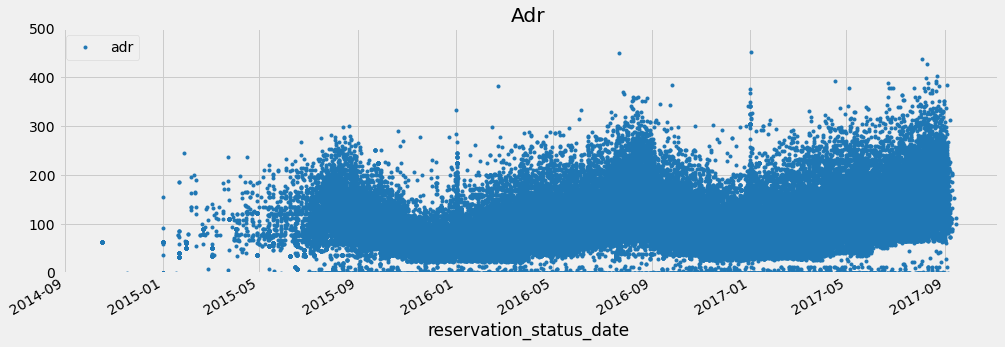

In [8]:
df.plot(style='.',
       figsize=(15,5),
       color=color_pal[0],
       title='Adr')
plt.ylim([0, 500])
plt.show()

### 1. Анализ выбросов и их удаление

<AxesSubplot:ylabel='Frequency'>

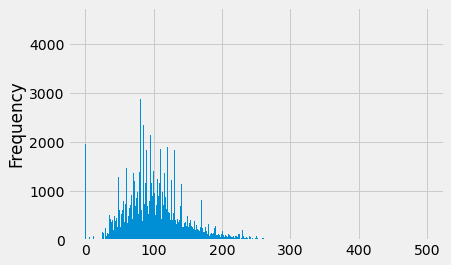

In [9]:
df['adr'].plot(kind='hist', bins=500, range=(0, 500))

In [10]:
# df.query('adr < 400')['adr']\
#         .plot(style='.',
#              figsize=(15,5),
#              color=color_pal[5],
#              title='outliers')
# plt.show()

In [11]:
df = df.query('adr < 400').copy()

### Рассмотрим Train / Test Split

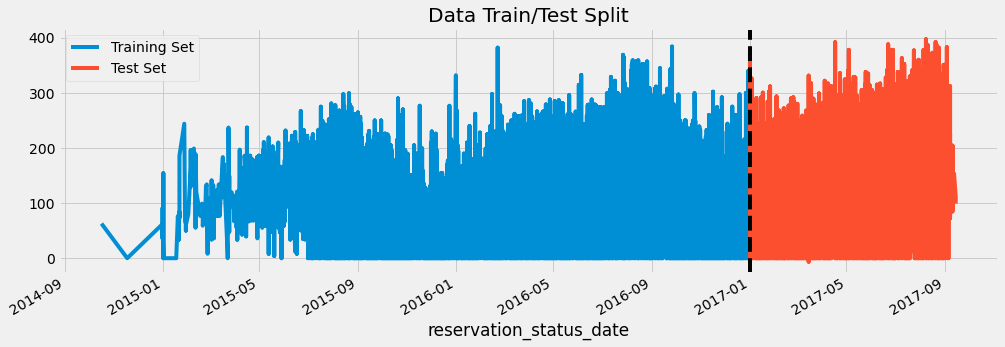

In [12]:
train = df.loc[df.index < '01-01-2017']
test = df.loc[df.index >= '01-01-2017']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(x='01-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### 1. Time Series Cross Validation

In [13]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

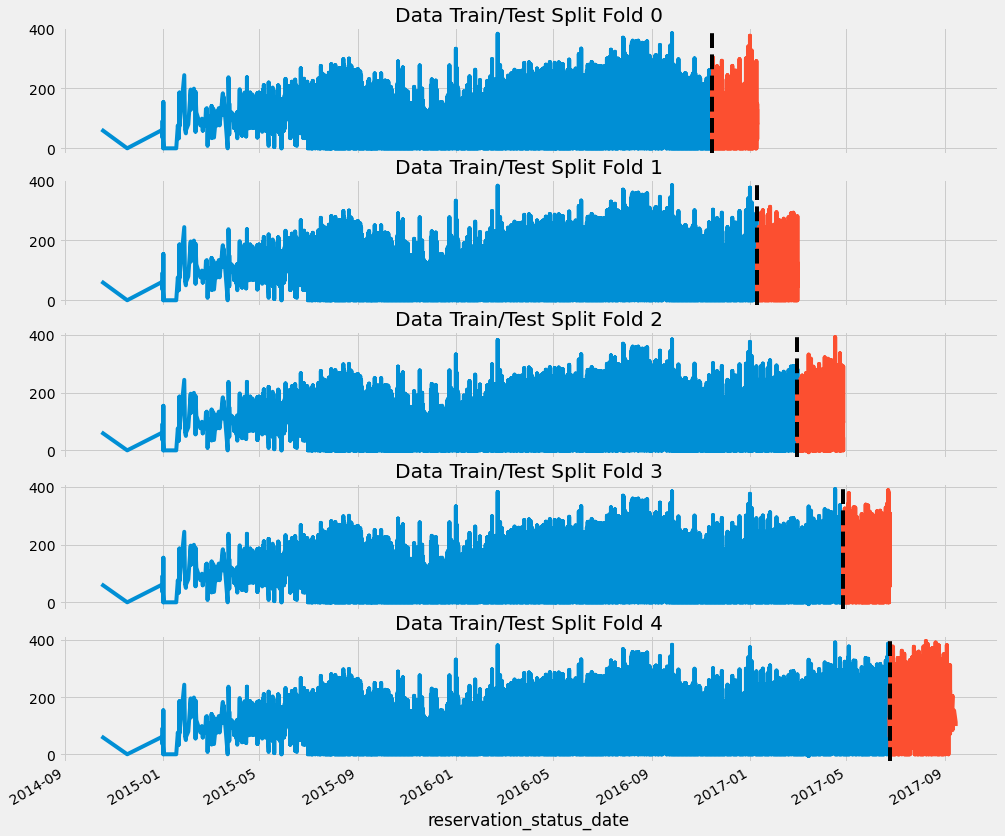

In [14]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['adr'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['adr'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### 2. Временые периоды для прогноза

In [15]:
def create_features(df):
    '''
    Create time series features based on time series index.
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [16]:
df.head(24)

,adr,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
reservation_status_date,,,,,,,,,
2014-10-17,62.8,0,4,4,10,2014,290,17,42
2014-10-17,62.8,0,4,4,10,2014,290,17,42
2014-10-17,62.8,0,4,4,10,2014,290,17,42
2014-10-17,62.8,0,4,4,10,2014,290,17,42
2014-10-17,62.8,0,4,4,10,2014,290,17,42
2014-10-17,62.8,0,4,4,10,2014,290,17,42
2014-10-17,62.8,0,4,4,10,2014,290,17,42
2014-10-17,62.8,0,4,4,10,2014,290,17,42
2014-10-17,62.8,0,4,4,10,2014,290,17,42


### Лаги в 3 месяца, пол года , 1 год


In [17]:
def add_lags(df):
    target_map = df['adr'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('91 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('182 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    return df

In [18]:
df = add_lags(df)

### Обучение с помощью  Cross Validation


In [19]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'adr'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[15:23:52] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:104.47136	validation_1-rmse:95.20265
[100]	validation_0-rmse:53.64096	validation_1-rmse:49.84623
[200]	validation_0-rmse:42.06235	validation_1-rmse:40.72057
[300]	validation_0-rmse:40.04911	validation_1-rmse:38.97207
[400]	validation_0-rmse:39.64873	validation_1-rmse:38.62118
[500]	validation_0-rmse:39.52983	validation_1-rmse:38.52223
[600]	validation_0-rmse:39.45223	validation_1-rmse:38.44403
[700]	validation_0-rmse:39.39508	validation_1-rmse:38.43169
[722]	validation_0-rmse:39.38335	validation_1-rmse:38.42814
[15:23:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:103.55180	validation_1-rmse:99.76510
[100]	validation_0-rmse:53.33395	validation_1-rm

In [20]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 47.1217
Fold scores:[38.4210701157338, 42.50329883842736, 48.63545400894556, 48.4483844016763, 57.60046299619894]


### 4. Прогноз

In [21]:
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'adr'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[15:24:24] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:111.15206
[100]	validation_0-rmse:57.29785
[200]	validation_0-rmse:44.97853
[300]	validation_0-rmse:42.80598
[400]	validation_0-rmse:42.38869
[499]	validation_0-rmse:42.26292


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

In [22]:
df.index.max()

Timestamp('2017-09-14 00:00:00')

In [23]:
future = pd.date_range('2017-09-14', '2018-09-14', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future  = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [24]:
future_w_features = df_and_future.query('isFuture').copy()

In [25]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

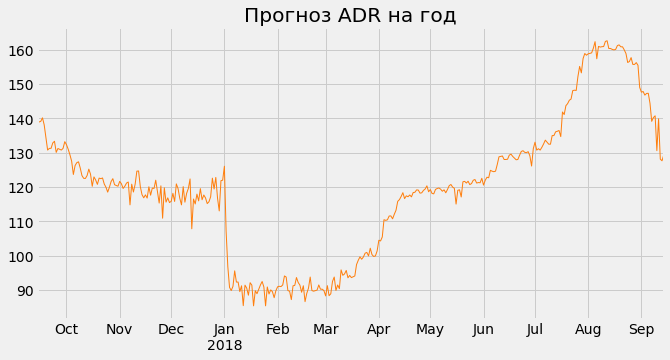

In [30]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1,
                               title='Прогноз ADR на год')
plt.show()

In [27]:
future_w_features.tail(50)

,adr,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture,pred
2018-07-27,NaN,0,4,3,7,2018,208,27,30,NaN,NaN,120.00,True,155.123749
2018-07-28,NaN,0,5,3,7,2018,209,28,30,NaN,NaN,80.10,True,153.244003
2018-07-29,NaN,0,6,3,7,2018,210,29,30,NaN,NaN,205.00,True,157.388412
2018-07-30,NaN,0,0,3,7,2018,211,30,31,NaN,NaN,171.00,True,158.877838
2018-07-31,NaN,0,1,3,7,2018,212,31,31,NaN,NaN,138.38,True,158.387100
2018-08-01,NaN,0,2,3,8,2018,213,1,31,NaN,NaN,160.00,True,158.800446
2018-08-02,NaN,0,3,3,8,2018,214,2,31,NaN,NaN,205.20,True,158.916031
2018-08-03,NaN,0,4,3,8,2018,215,3,31,NaN,NaN,210.00,True,159.067291
2018-08-04,NaN,0,5,3,8,2018,216,4,31,NaN,NaN,295.00,True,160.437897
2018-08-05,NaN,0,6,3,8,2018,217,5,31,NaN,NaN,253.00,True,162.323914


### Сохраним обученную модель

In [28]:
reg.save_model('model.json')

<AxesSubplot:title={'center':'Future Predictions'}>

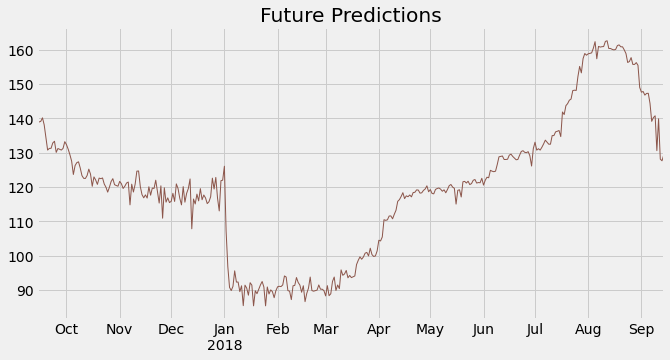

In [29]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[5],
                               ms=1, lw=1,
                               title='Прогноз ADR на год')